### Transfer Learning With Help Of InceptionV3 model 

In [15]:
import os
import random 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top = False,
                                weights=None)
pre_trained_model.load_weights(local_weights_file)

In [3]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [4]:
last_layer = pre_trained_model.get_layer('mixed7')
print("last layer output shape: ",last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [5]:
from tensorflow.keras.optimizers import RMSprop

In [6]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

new_model = Model(pre_trained_model.input, x) 


In [7]:
print(new_model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
new_model.compile(optimizer = RMSprop(lr=0.0001),
                  loss='binary_crossentropy',
                  metrics = ['accuracy'])

In [9]:
#define our example directory

base_dir = 'base_dir'

In [10]:
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

In [11]:
train_cats_dir = os.path.join(train_dir,'cats') #cats directory
train_dogs_dir = os.path.join(train_dir,'dogs') #dogs directory
validation_cats_dir = os.path.join(train_dir,'cats') #cats validation directoru
validation_dogs_dir = os.path.join(train_dir,'dog') #dogs validation directory

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

In [12]:
# Image data generator for data augumentation
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# validation data should not be augmented
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 15,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 15,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2002 images belonging to 2 classes.
Found 2002 images belonging to 2 classes.


In [13]:
hist = new_model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch= 100,
            epochs = 5,
            validation_steps = 50,
            verbose = 2)

Epoch 1/5
100/100 - 143s - loss: 0.3439 - accuracy: 0.8760 - val_loss: 0.1806 - val_accuracy: 0.9200
Epoch 2/5
100/100 - 139s - loss: 0.2420 - accuracy: 0.9082 - val_loss: 0.1220 - val_accuracy: 0.9587
Epoch 3/5
100/100 - 143s - loss: 0.2392 - accuracy: 0.9149 - val_loss: 0.1083 - val_accuracy: 0.9573
Epoch 4/5
100/100 - 197s - loss: 0.2237 - accuracy: 0.9162 - val_loss: 0.0696 - val_accuracy: 0.9747
Epoch 5/5
100/100 - 211s - loss: 0.1978 - accuracy: 0.9303 - val_loss: 0.0966 - val_accuracy: 0.9680


In [16]:
import matplotlib.pyplot as plt

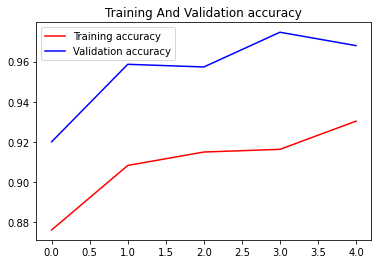

<Figure size 432x288 with 0 Axes>

In [17]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r',label='Training accuracy')
plt.plot(epochs,val_acc,'b',label='Validation accuracy')
plt.title('Training And Validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()